# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# Import your chosen baseline model
%pip install --upgrade pip
%pip install scikit-survival
import sksurv 

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

from sklearn import set_config
from sklearn.preprocessing import OrdinalEncoder


from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Model Choice: Survival Analysis

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]

As one of the main goals is to predict the overall survival of AML-patients, the decision of a baseline-Model fell on building a survival Analysis model.

A survival Analysis model (build with scikit-survival sksurv) is a special kind of analysis. The Cox's proportional hazards model is kind of similar to regression but takes the cumulative hazards function in the presence of addidional covariants into account.
The Survival analysis describes a time-to event regression problem which is different to a regular regression due to "censoring". 

Censored data can occur as right censoring (event was not observed in timeframe), left censoring (event occured before start of the study timeframe) or interval censoring (event occured in an roughly described time interval, but the exact time is unknown)

The dataset of Acute Myeloic Leukemia (AML) patients contains medical and biological data, as well as a status of "alive" or "dead" on the last follow-up. The dataset is affected by "right censoring", which indicates that not every patient made it to the endpoint of data collection or didn't experience the "event" while the duration of the observation- timeframe. The left censoring also affects the given dataset, as some patients probably died before or right at the start of the observation timeframe. 

For the application of the survival analysis with the scikit-survival package, some more tailored steps of data processing are required, compared to the regular processing of most other modelling packages. This means, the categorical data has to be encoded by usage of the One hot Encoder and the data hast to be compiled to arrays then, to run the survival analysis.




## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]

The overall survival prediction will be based on the generation of a risk score through the evaluation of the status (alive or dead) OS_STATUS, as event indicator and with the time measurements of survival in years OS_YEARS after last follow-up as time variable.

One of he main obstacles in working with censored data is choosing an unbiased estimator of the survival curve. There are different approaches like the Kaplan-Meyer survival probability.

Feature selection could be done randomly, or by differentiation of weighting risk-factors which would be highly desired in health-related fields.

Some main features of AML described in literature are the presence of blast cells in percentage (column 'BM_BLAST'), low concentration of Hemoglobine levels, resulting in anemia (column 'HB') as well as low levels of platelets (column 'PLT').

One of the main used models for survival predictions in the medical field is the Cox's proportional hazards model.

Survival function: S(t) 
- probability of an individual to survive longer than an specific time t.

Hazard function
- quantification of a risk of event occurence within a short time interval, when the individual lives up to a known time  t.

Cumulative hazard function
- the cumulative risk of occurence of an event up to the time t. 

Probability density function of survival time
- the probability of individuals to survive a short time interval.

In the recent years, several Machine Learning survival algorithms have been developed to handle complex and cencored time-to-event data. One of the established algorithms is named random survival forests


In [2]:
import os

os.chdir("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics")

print(os.getcwd())

# Load the datasets

# Clinical Data
cln_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical.csv"
)  # clinical_train
cln_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical_eval.csv"
)  # clinical_test

# Molecular Data
maf_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular.csv"
)  # molecular_train
maf_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular_eval.csv"
)  # molecular_test

target_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_outcome.csv"
)  # target_train
target_df_test = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/ChallengeData/random_submission_FRacdcw_v9kP4pP.csv"
)  # target_test risk scores

# Preview the data
print(cln_df.head())
# number of rows
print("Clinical Data Rows: ", cln_df.shape[0])
print("Clinical Data Columns: ", cln_df.shape[1])

print(maf_df.head())
# number of rows
print("Molecular Data Rows: ", maf_df.shape[0])
print("Molecular Data Columns: ", maf_df.shape[1])

print(target_df.head())
# number of rows
print("Target Data Rows: ", target_df.shape[0])
print("Target Data Columns: ", target_df.shape[1])

/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics
        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS  
0      46,xy,del(20)(q12)[2]/46,xy[18]  
1                                46,xx  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  
Clinical Data Rows:  3323
Clinical Data Columns:  9
        ID CHR        START          END                REF ALT    GENE  \
0  P100000  11  119149248.0  119149248.0                  G   A     CBL   
1  P100000   5  131822301.0  131822301.0                  G   T    IRF1   
2  P100000   

In [3]:
# Data preparation of clinical data

# Convert 'OS_YEARS' to numeric
target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")
# Convert 'OS_STATUS' to boolean (1 for event, 0 for censored)
target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)

# Select features
features = ["BM_BLAST", "HB", "PLT"]
target = ["OS_YEARS", "OS_STATUS"]

# check for common IDs in clinical and target data
print("IDs in cln_df:", cln_df["ID"].nunique())
print("IDs in target_df:", target_df["ID"].nunique())
print("Common IDs:", len(set(cln_df["ID"]).intersection(set(target_df["ID"]))))

# Check if the columns exist
print(cln_df.columns)
print(target_df.columns)

IDs in cln_df: 3323
IDs in target_df: 3323
Common IDs: 3323
Index(['ID', 'CENTER', 'BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT',
       'CYTOGENETICS'],
      dtype='object')
Index(['ID', 'OS_YEARS', 'OS_STATUS'], dtype='object')


In [4]:
# Create the survival data format
# X = cln_df[features]
# Ensure that the target_df has the same IDs as cln_df for matching
# target_df = target_df[target_df["ID"].isin(cln_df["ID"])]
# Filter cln_df to only include rows with IDs present in target_df

X = cln_df.loc[cln_df["ID"].isin(target_df["ID"]), features]

# X = cln_df[cln_df["ID"].isin(target_df["ID"]), features]
y = Surv.from_dataframe("OS_STATUS", "OS_YEARS", target_df)

# Check shapes before splitting
print(X.shape)  # Should be (3173, n_features)
print(len(y))  # Should be 3173

# Only call train_test_split if shapes match and are non-zero
if X.shape[0] == len(y) and X.shape[0] > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
else:
    print(
        "Mismatch or empty data: X has", X.shape[0], "rows, y has", y.shape[0], "rows."
    )

# print rows of y

(3323, 3)
3323


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [8]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv("your_dataset.csv")

# Feature selection
# Example: Selecting only two features for a simple baseline model
X = df[["feature1", "feature2"]]
y = df["target_variable"]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

FileNotFoundError: [Errno 2] No such file or directory: 'your_dataset.csv'

## Implementation

[Implement your baseline model here.]



In [ ]:
# Initialize and train the baseline model
# Example for a classification problem using Logistic Regression
# model = LogisticRegression()
# model.fit(X_train, y_train)

# Your implementation code here

Note: you may need to restart the kernel to use updated packages.


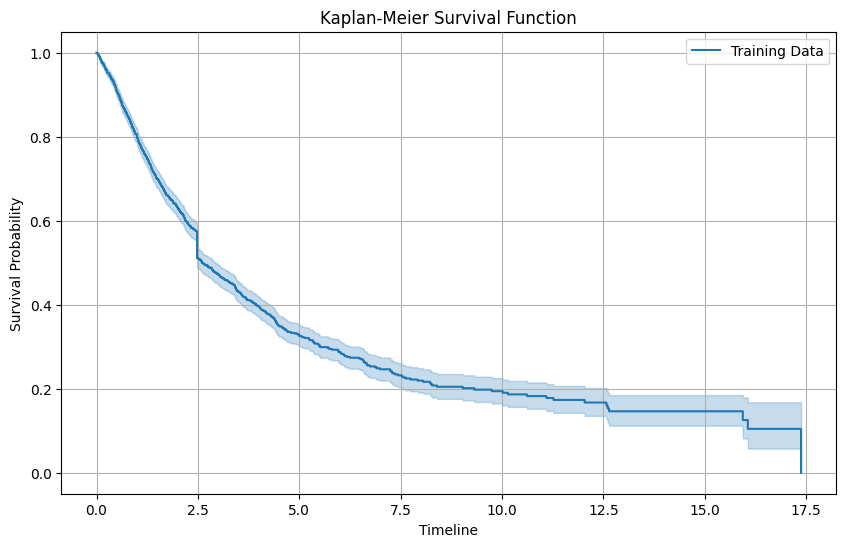

In [38]:
import matplotlib.pyplot as plt
# Import the Kaplan-Meier fitter from lifelines
%pip install lifelines
from lifelines import KaplanMeierFitter 

kmf = KaplanMeierFitter()

# Apply Kaplan-Meier survival analysis

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])
#kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])

# Plot the kaplan-meier survival function of training data

#kmf.plot_survival_function(label="y_train: Kaplan-Meier Survival Function", ci_show=True)

plt.figure(figsize=(10, 6))
kmf.plot()



plt.xlabel("Timeline")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Function")
plt.legend(["Training Data"])
plt.grid(True)
#plt.tight_layout()
plt.show()


# Evaluate the model

<Axes: xlabel='timeline'>

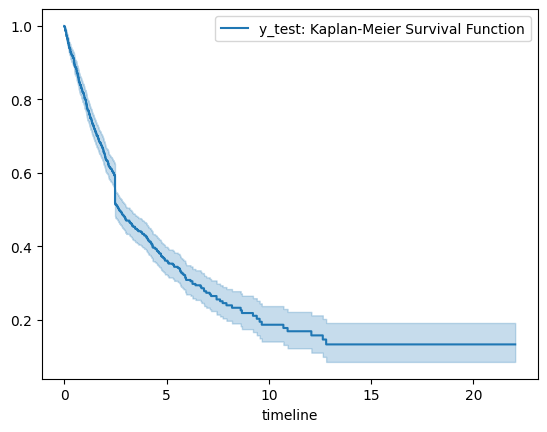

In [23]:
kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])

# Plot the kaplan-meier survival function of test data

kmf.plot_survival_function(label="y_test: Kaplan-Meier Survival Function", ci_show=True)

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



In [ ]:
# Evaluate the baseline model
# Example for a classification problem
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# For a regression problem, you might use:
# mse = mean_squared_error(y_test, y_pred)

# Your evaluation code here